# Exploratory Data Analysis Using H3 Hexagonal Modeling

In [1]:
import pandas as pd
import snowflake.connector
import os
from datetime import datetime
from dotenv import load_dotenv

import folium
from folium.plugins import HeatMap
import h3

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Polygon

## 1. Import Data
#### 1.1 Load Snowflake credentials for temp user

In [2]:
# Load environment variables from a .env file
load_dotenv()

try:
    TEMP_USER = os.getenv('SNOWSQL_TEMP_USER')
    TEMP_USER_PASSWORD = os.getenv('SNOWSQL_TEMP_PWD')
    ACCOUNT = os.getenv('SNOWFLAKE_ACCOUNT')
    
    if not TEMP_USER:
        raise ValueError("Environment variable SNOWSQL_TEMP_USER must be set")
    if not TEMP_USER_PASSWORD:
        raise ValueError("Environment variable SNOWSQL_TEMP_PWD must be set")

except ValueError as ve:
    print(f"Error: {ve}")
    
except Exception as e:
    print(f"An unexpected error occurred: {e}")

#### 1.2 Connect to Snowflake

In [3]:
# Establish connection to Snowflake
current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')

try:
    conn = snowflake.connector.connect(
        user=TEMP_USER,
        password=TEMP_USER_PASSWORD,
        account=ACCOUNT,
        warehouse='COMPUTE_WH',
        database='AIRBNB',
        schema='FEATURE_STORE'
    )

    print(f'Connected to Snowflake successfully at {current_time}')

except Exception as e:
    print(f'Failed to connect to Snowflake on {current_time} due to error code {e}')

Connected to Snowflake successfully at 2024-08-07 21:4943


#### 1.3 Load `listings_cleaned` data from feature_store schema

In [4]:
def get_data(sql_query, date_columns=None):
    """
    Executes a SQL query and returns the result as a pandas DataFrame.

    Args:
        sql_query (str): SQL query to execute.

    Returns:
        df_result: Resulting DataFrame from the SQL query.
    """
    try:
        cursor = conn.cursor()
        
        cursor.execute(sql_query)

        # load data into dataframe
        df_result = cursor.fetch_pandas_all()

        # Convert column names to lowercase
        df_result.columns = map(str.lower, df_result.columns)

        # Parse specified date columns
        if date_columns:
            for col in date_columns:
                df_result[col] = pd.to_datetime(df_result[col], errors='coerce')

    finally:
        if cursor is not None:
            cursor.close()

    return df_result

In [5]:
sql_query = '''
select * from "listings_cleaned"
 '''

df = get_data(sql_query)
df.shape

(81352, 9)

In [6]:
df.head(3)

,market,room_type,accommodates,bathrooms,beds,latitude,longitude,amenities,price
0,albany,Private room,2,1.0,0.0,42.66719,-73.81580,"Heating, Backyard, Dishes and silverware, Wifi...",50.0
1,albany,Entire home/apt,2,1.0,1.0,42.65222,-73.76724,"Heating, Hangers, Pets allowed, Dishes and sil...",118.0
2,albany,Entire home/apt,2,1.0,1.0,42.64615,-73.75966,"Luggage dropoff allowed, Heating, Hangers, Bac...",90.0


## 2. Exploratory Data Analysis
#### 2.1 Check for missing data

In [7]:
missing_percentage = df.isnull().mean() * 100
missing_percentage.sort_values(ascending=False)

beds            0.501524
bathrooms       0.023355
market          0.000000
room_type       0.000000
accommodates    0.000000
latitude        0.000000
longitude       0.000000
amenities       0.000000
price           0.000000
dtype: float64

#### 2.2 Review distribution of listings for beds and bathrooms

In [8]:
# count the number of listings per beds count
df['beds'].value_counts().reset_index()

,beds,count
0,1.0,38373
1,2.0,19346
2,3.0,9359
3,0.0,4968
4,4.0,4931
5,5.0,2033
6,6.0,1034
7,7.0,405
8,8.0,240
9,9.0,109


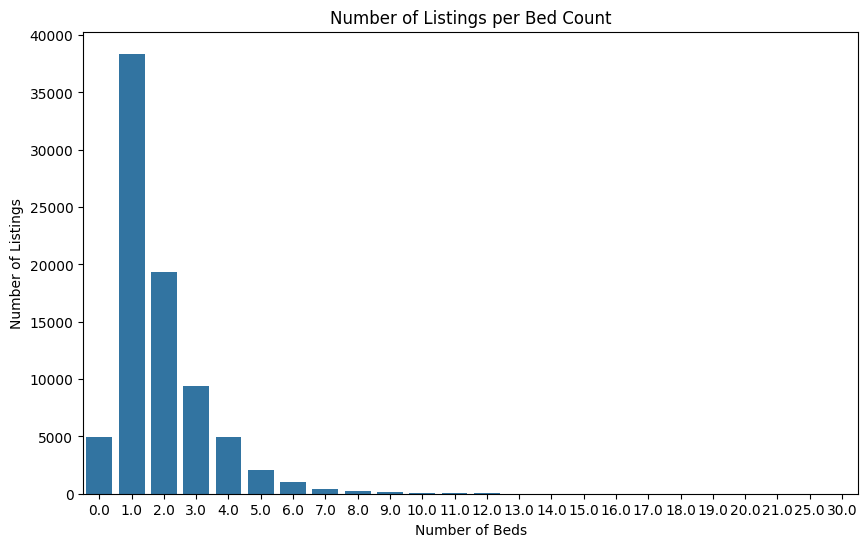

In [9]:
# Create a Seaborn bar plot (count plot) for the number of beds
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='beds', order=sorted(df['beds'].dropna().unique()))

# Add titles and labels
plt.title('Number of Listings per Bed Count')
plt.xlabel('Number of Beds')
plt.ylabel('Number of Listings')

# Display the plot
plt.show()

In [10]:
# count the number of listings per bathroom count
df['bathrooms'].value_counts().reset_index()

,bathrooms,count
0,1.0,57363
1,2.0,12843
2,1.5,4060
3,2.5,2340
4,3.0,2219
5,0.0,728
6,3.5,699
7,4.0,508
8,0.5,189
9,4.5,164


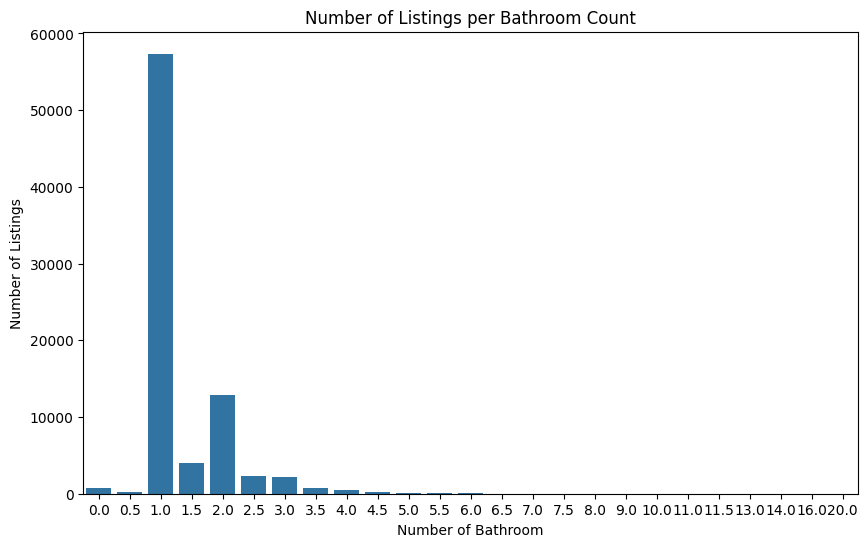

In [11]:
# Create a Seaborn bar plot (count plot) for the number of beds
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='bathrooms', order=sorted(df['bathrooms'].dropna().unique()))

# Add titles and labels
plt.title('Number of Listings per Bathroom Count')
plt.xlabel('Number of Bathroom')
plt.ylabel('Number of Listings')

# Display the plot
plt.show()

#### 2.3 Impute missing values for beds and bathrooms

In [12]:
df.loc[:, 'bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
df.loc[:, 'beds'] = df['beds'].fillna(df['beds'].mode()[0])


In [13]:
df.isnull().sum()

market          0
room_type       0
accommodates    0
bathrooms       0
beds            0
latitude        0
longitude       0
amenities       0
price           0
dtype: int64

#### 2.4 Review distribution of rental prices for markets

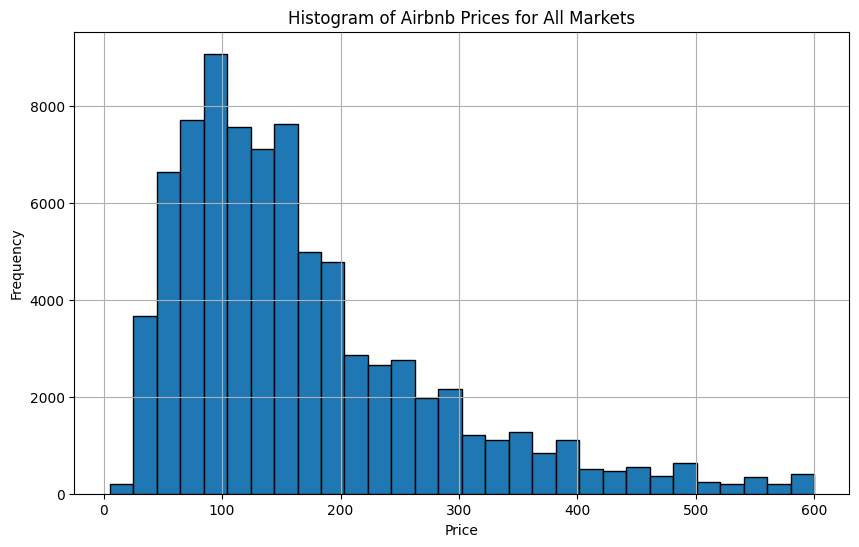

In [14]:
# Plot the histogram
plt.figure(figsize=(10, 6))

# Drop NaN values and create the histogram
plt.hist(df['price'].dropna(), bins=30, edgecolor='black')

# Add titles and labels
plt.title('Histogram of Airbnb Prices for All Markets')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Display grid for better readability
plt.grid(True)

# Show the plot
plt.show()

<Axes: title={'center': 'Boxplot of Airbnb Prices for Each Market'}, xlabel='market', ylabel='price'>

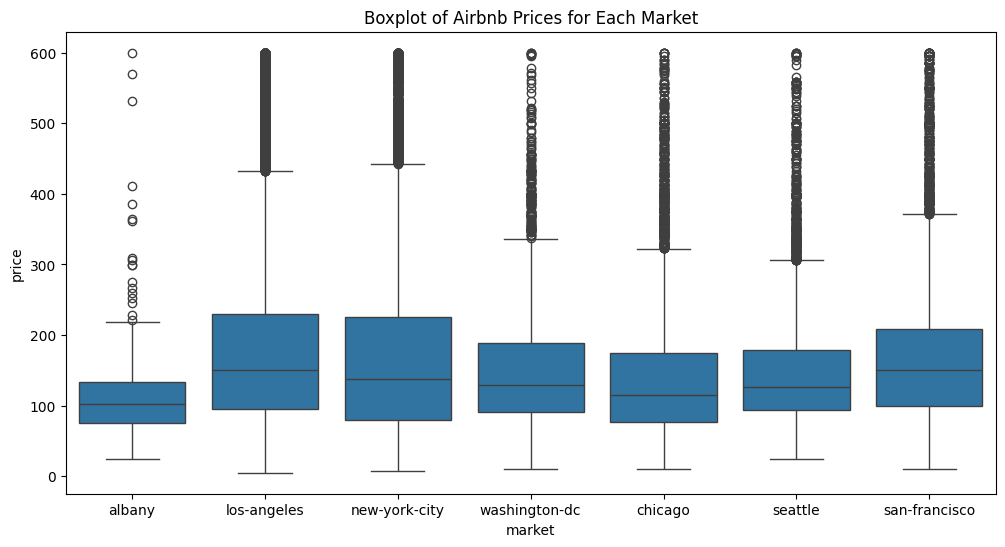

In [15]:
# Create a Seaborn boxplot for rental prices
plt.figure(figsize=(12, 6))
plt.title('Boxplot of Airbnb Prices for Each Market')
sns.boxplot(data=df, x='market', y='price')

#### 2.5 Remove outlier rental price for each market
need to write details about why this method was chosen

In [16]:
def filter_outliers_by_market(df, location_column='market', price_column='price'):
    """
    Filters out outliers from the dataset based on IQR for each market.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing market and price information.
        location_column (str): The column name indicating market locations (default is 'market').
        price_column (str): The column name containing price data (default is 'price').
        
    Returns:
        pd.DataFrame: The DataFrame with outliers removed.
    """
    # List to store filtered dataframes
    filtered_dataframes = []
    
    # Get unique markets
    markets = df[location_column].unique()
    
    # Iterate through each market
    for market in markets:
        # Filter data for the current market
        market_data = df[df[location_column] == market]
        
        # Calculate IQR for the 'price' column in this market
        Q1 = market_data[price_column].quantile(0.25)
        Q3 = market_data[price_column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Determine outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        market_filtered = market_data[(market_data[price_column] >= lower_bound) & (market_data[price_column] <= upper_bound)]
        
        # Append the filtered data to the list
        filtered_dataframes.append(market_filtered)
    
    # Concatenate all filtered dataframes
    filtered_df = pd.concat(filtered_dataframes, ignore_index=True)
    
    return filtered_df

In [17]:
df_cleaned = filter_outliers_by_market(df, location_column='market', price_column='price')
df_cleaned.head(3)

,market,room_type,accommodates,bathrooms,beds,latitude,longitude,amenities,price
0,albany,Private room,2,1.0,0.0,42.66719,-73.81580,"Heating, Backyard, Dishes and silverware, Wifi...",50.0
1,albany,Entire home/apt,2,1.0,1.0,42.65222,-73.76724,"Heating, Hangers, Pets allowed, Dishes and sil...",118.0
2,albany,Entire home/apt,2,1.0,1.0,42.64615,-73.75966,"Luggage dropoff allowed, Heating, Hangers, Bac...",90.0


#### 2.6 Review impact of outlier removal for prices

<Axes: title={'center': 'Impact of Removing Outliers:  Boxplot of Airbnb Prices for Each Market'}, xlabel='market', ylabel='price'>

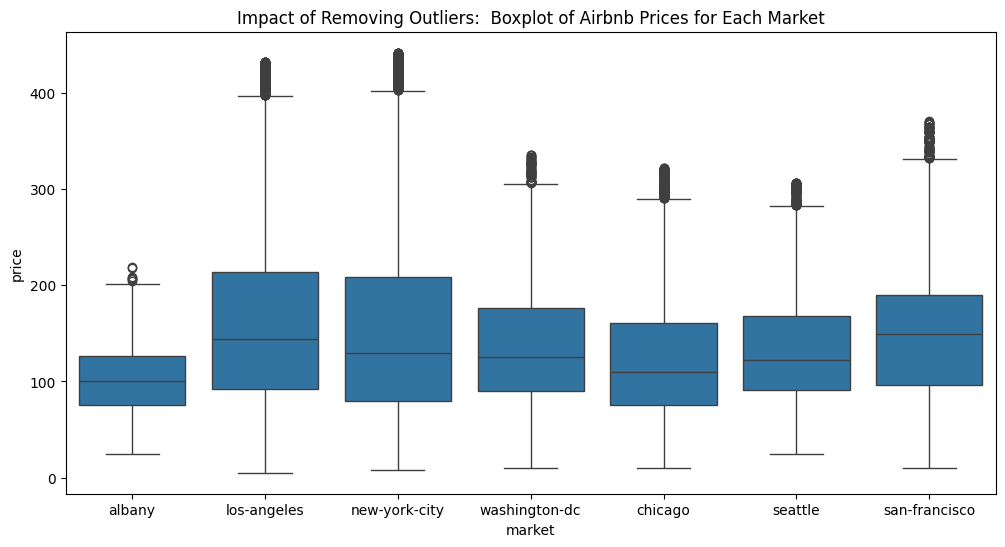

In [18]:
# Create a Seaborn boxplot for rental prices
plt.figure(figsize=(12, 6))
plt.title('Impact of Removing Outliers:  Boxplot of Airbnb Prices for Each Market')
sns.boxplot(data=df_cleaned, x='market', y='price')

## 3. Apply H3 indexing to Airbnb listings
#### 3.1 Define H3 Resolution and create function to apply h3 hexagons to each listing
Discuss why a resoultion of size 7 was used.

In [19]:
# Define the resolution level (0-15)
resolution = 7

# Function to get H3 index from latitude and longitude
def get_h3_index(lat, lon):
    return h3.geo_to_h3(lat, lon, resolution)

# Apply the function to get H3 indices
df_cleaned['h3_index'] = df_cleaned.apply(lambda row: get_h3_index(row['latitude'], row['longitude']), axis=1)

# Convert H3 index to Geo-coordinates (boundary)
def h3_to_geo_boundary(h3_index):
    """Convert H3 index to a list of latitude-longitude pairs."""
    return h3.h3_to_geo_boundary(h3_index, geo_json=True)

#### 3.2 Aggregate data by H3 index

In [20]:
# Group by H3 index and compute the average for each useful attribute
hexagon_aggregated_data = df_cleaned.groupby(['h3_index','market']).agg({
    'accommodates': 'median',
    'bathrooms': 'median',
    'beds': 'median',
    'price': 'median'
}).reset_index()

hexagon_aggregated_data.rename(columns={
    'accommodates': 'accommodates_median',
    'bathrooms': 'bathrooms_median',
    'beds': 'beds_median',
    'price': 'price_median'
}, inplace=True)

In [22]:
hexagon_aggregated_data.columns

Index(['h3_index', 'market', 'accommodates_median', 'bathrooms_median',
       'beds_median', 'price_median'],
      dtype='object')

#### 3.3 Merge aggregated data back to original dataFrame

In [26]:
selected_cols = ['h3_index', 'accommodates_median', 'bathrooms_median','beds_median', 'price_median']
# Merge the aggregated data back to the original DataFrame
df_with_aggregated_features = df_cleaned.merge(hexagon_aggregated_data[selected_cols], on='h3_index')

# Drop the 'h3_index' column and amenities
df_with_aggregated_features = df_with_aggregated_features.drop(columns=['amenities'])

#### 3.4 Convert H3 index to polygon to get the geographical boundaries

In [27]:
# Function to get polygon from H3 index
def h3_index_to_polygon(h3_index):
    return Polygon(h3.h3_to_geo_boundary(h3_index, geo_json=True))

# Add geometry column with hexagon polygons
hexagon_aggregated_data['geometry'] = hexagon_aggregated_data['h3_index'].apply(h3_index_to_polygon)
gdf = gpd.GeoDataFrame(hexagon_aggregated_data, geometry='geometry')
gdf.crs = 'EPSG:4326'  # CRS for latitude and longitude coordinates

#### 3.5 Write to GeoJSON and CSV

In [34]:
gdf.to_file('hexagon_data.geojson', driver='GeoJSON')
hexagon_aggregated_data.to_csv('hexagon_data.csv', index=False)

## 4. Explore Median Prices Using Hexagons

In [29]:
df_cleaned.market.unique()

array(['albany', 'los-angeles', 'new-york-city', 'washington-dc',
       'chicago', 'seattle', 'san-francisco'], dtype=object)

In [31]:
# Initialize a Folium map centered New York City market
newyork_latitude_center = df_cleaned[df_cleaned['market'] == 'new-york-city']['latitude'].mean()
newyork_longitude_center = df_cleaned[df_cleaned['market'] == 'new-york-city']['longitude'].mean()
m = folium.Map(location=[newyork_latitude_center, newyork_longitude_center], zoom_start=10, tiles='cartodbdark_matter')

# Add Choropleth layer
folium.Choropleth(
    geo_data='hexagon_data.geojson',
    data=hexagon_aggregated_data,
    columns=['h3_index', 'price_median'],
    key_on='feature.properties.h3_index',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Median Price'
).add_to(m)

# Add additional tile layers (optional)
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save or display the map
m.save('map.html')

In [32]:
m

## 5. Write data to Snowflake
#### 5.1 Connect to FEATURE_STORE schema

In [ ]:
# Establish connection to Snowflake
current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')

try:
    conn = snowflake.connector.connect(
        user=TEMP_USER,
        password=TEMP_USER_PASSWORD,
        account=ACCOUNT,
        warehouse='COMPUTE_WH',
        database='AIRBNB',
        schema='FEATURE_STORE' # connect to feature_store
    )

    print(f'Connected to Snowflake successfully at {current_time}')

except Exception as e:
    print(f'Failed to connect to Snowflake on {current_time} due to error code {e}')

#### 5.2 Upload to Snowflake

In [ ]:
from snowflake.connector.pandas_tools import write_pandas

In [ ]:
def write_to_snowflake(df_name, snowflake_table_name):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')
    try:
        success, num_chunks, num_rows, output = write_pandas(
            conn=conn,
            df=df_name,
            schema='FEATURE_STORE', # schema needs to be capitalized
            table_name=snowflake_table_name,
            auto_create_table=True,
            overwrite=True
        )

        print(f'Table created in Snowflake and data uplaoded at {current_time}')

    except Exception as e:
        print(f'Failed to create table and load data to Snowflake due to error code {e}')

In [ ]:
write_to_snowflake(df_with_aggregated_features, snowflake_table_name = "LISTINGS_CLEANED_H3")

In [ ]:
columns_to_keep = ['h3_index','accommodates_median','bathrooms_median','bedrooms_median','price_median']

# write data to Snowflake except for polygom column
write_to_snowflake(hexagon_aggregated_data[columns_to_keep], snowflake_table_name = "HEXAGON_AGGREGATED_DATA")